# CIS 5200 Final Project: Whale and Dolphin Identification
Author: Luyang Xie, Xiuxian Li

# Summary Notebook

The main goal of our project is to implement different deep-learning techniques to identify whales and dolphins based on the previous images. We mainly achieve four deep learning methods in our projects, including three pre-trained models (ResNet-50, DenseNet-121, and ConvNeXt) and a vanilla CNN model. According to the overall performance comparison, the ConvNeXt exhibits the best performance and achieved 0.83 test accuracy. Both ResNet-50 and DenseNet-121 are pre-trained models. To fine-tuning that, we manually freeze the first and third blocks and adjusted the output channels to 29. In our previous experiments, more dense layers added on the end of the models were not affected much, so we decided to remove that. In the test section, the ResNet-50 achieved 0.74 accuracy, and the DenseNet achieved 0.75 accuracy. The ConvNeXt is another method, which is entirely from standard Convnet modules, and it is more favorable in accuracy and scalability than Swin-Transforms(state-of-art vision transformers method). During our project, we adjusted little on this model and got 0.81 accuracy on the test section.  

Besides the deep learning model discussion, we found data augmentation essential to the image classification task. For example, by observing the RGB distribution and width-length ratio on different training images, we found a significant difference between various train images of the RGB value and the target-image size ratio. Also, the class imbalanced needed to be handled as well. Thus, we selected several data augmentation (i.e., RGB shift, Horizontal Flip) methods to get a better result.

# Import Package and Load Data

Get access to google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install package and import library.

In [ ]:
!pip install pretrainedmodels > /dev/null
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-q_aa9xgg



In [ ]:
import numpy as np
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
import cv2
import PIL
import sys
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as T

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

from tensorflow.keras.utils import load_img, img_to_array 
from tensorflow.python.keras import layers
import tensorflow.python.keras.backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import Sequential

from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from tensorflow.python.keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pretrainedmodels


from PIL import Image

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)


# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.5.4 
    
from timm import create_model

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import train and validation data that are pre-split.

In [ ]:
ROOT_DIR = '/content/drive/MyDrive/HappyWhale'
TRAIN_DIR = '/content/drive/MyDrive/HappyWhale/train_images'
TEST_DIR = '/content/drive/MyDrive/HappyWhale/test_images'
SPLIT_TRAIN_DIR = '/content/drive/MyDrive/HappyWhale_split_1124/train_split_0.02/'
SPLIT_TEST_DIR = '/content/drive/MyDrive/HappyWhale_split_1124/test_split_0.01/'

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/HappyWhale_split_1124/train_bin_split.csv')
train_df.head()

image         species individual_id bi_label  label
0  00a198105cdc24.jpg  humpback_whale  da611bc6c389    whale      1
1  00b0f5aa111833.jpg   dusky_dolphin  5015b9e45c33  dolphin      0
2  0104c0fd90132f.jpg   dusky_dolphin  dc20a069583b  dolphin      0
3  018490eafcf301.jpg      gray_whale  2ca0b9b39092    whale      1
4  01bff0f0e91901.jpg     pilot_whale  f73a3d94632c    whale      1

In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/HappyWhale_split_1124/val_0.004.csv', )
print(val_df.shape)
val_df.head()

(200, 3)


image                   species individual_id
0  02c06642e316e9.jpg                    beluga  5ac053677ed1
1  03dc56a17669dc.jpg  short_finned_pilot_whale  cafd17420e8d
2  078f69a0902d4f.jpg           spotted_dolphin  375b78224163
3  07eb9c70f6e26b.jpg             dusky_dolphin  da18a6428df1
4  07ecde326c4ab2.jpg            humpback_whale  ca69a5d7c122

In [ ]:
train_image = read_file("/content/drive/MyDrive/HappyWhale_split_1124/train_split_0.02")
len(train_image)

1007

In [ ]:
val_image = read_file("/content/drive/MyDrive/HappyWhale_split_1124/val_split_0.004")
len(val_image)

199


# Data Wrangling and Visualization

## Data Distribution

In [ ]:
# Print the Number of training images after split
print('Number train images:', len(train_image))
# Print the Number of testing images after split
print('Number test images:', len(val_image))

Number train images: 1007
Number test images: 199


In [ ]:
# Print the number of images in each species
sorted_species = train_df["species"].value_counts()
print(sorted_species)

bottlenose_dolphin           189
humpback_whale               155
beluga                       134
blue_whale                   105
false_killer_whale            75
dusky_dolphin                 64
minke_whale                   35
killer_whale                  30
spinner_dolphin               29
bottlenose_dolpin             29
melon_headed_whale            28
fin_whale                     25
gray_whale                    23
southern_right_whale          18
kiler_whale                   15
sei_whale                     11
spotted_dolphin                9
short_finned_pilot_whale       8
common_dolphin                 6
pilot_whale                    6
cuviers_beaked_whale           5
pantropic_spotted_dolphin      5
commersons_dolphin             3
white_sided_dolphin            3
long_finned_pilot_whale        3
globis                         3
brydes_whale                   2
frasiers_dolphin               1
pygmy_killer_whale             1
Name: species, dtype: int64


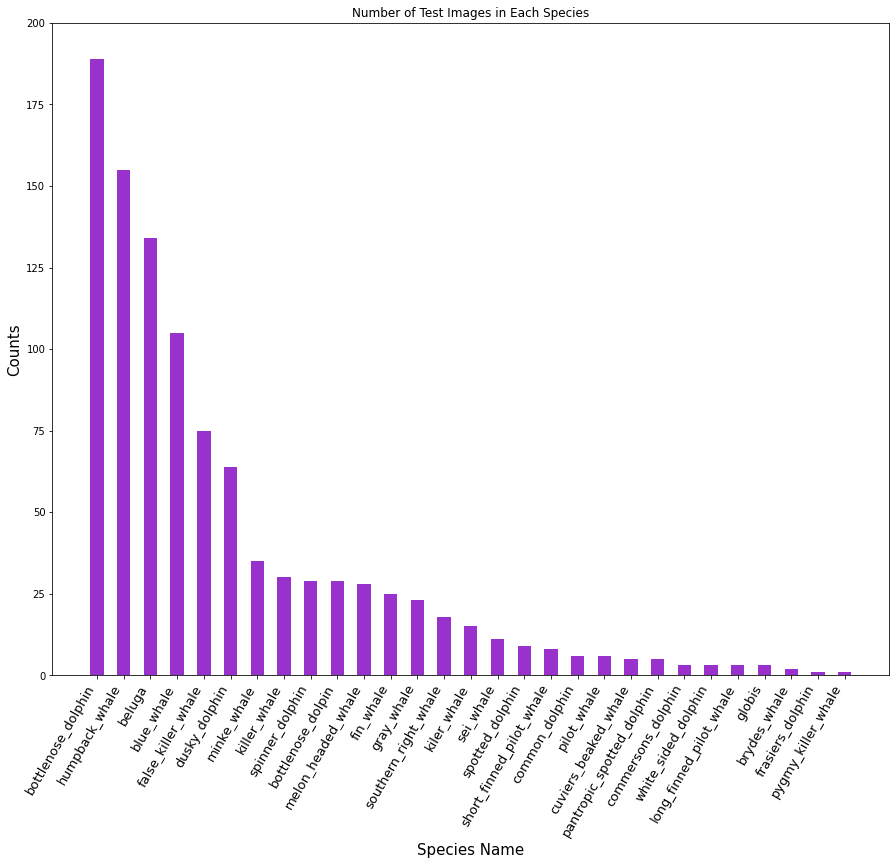

In [ ]:
# Plot the barchart of each species 
plt.figure(figsize=(15, 12))
plt.bar(sorted_species.index, sorted_species, color='darkorchid', width=0.5)
plt.ylim([0, 200])
plt.gca().set_xticklabels(sorted_species.index, rotation=60, horizontalalignment= 'right', fontsize=13)
plt.title('Number of Test Images in Each Species')
plt.xlabel('Species Name', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.show()

In [ ]:
# Print pie chart of each species
fig = px.pie(train_df, values=sorted_species.values, names=sorted_species.index, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

To solve the class imbalance problem, we try to transform the multi-class problem to a binary classification issue.

In [ ]:
# creating new binary label in train.csv

train_df['bi_label'] = train_df.species.map(lambda x: 'whale' if 'whale' in x else 'dolphin')

In [ ]:
train_df.head()

image         species individual_id bi_label
0  00a198105cdc24.jpg  humpback_whale  da611bc6c389    whale
1  00b0f5aa111833.jpg   dusky_dolphin  5015b9e45c33  dolphin
2  0104c0fd90132f.jpg   dusky_dolphin  dc20a069583b  dolphin
3  018490eafcf301.jpg      gray_whale  2ca0b9b39092    whale
4  01bff0f0e91901.jpg     pilot_whale  f73a3d94632c    whale

In [ ]:
label_count = train_df['bi_label'].value_counts()
label_count

whale      545
dolphin    475
Name: bi_label, dtype: int64

In [ ]:
# plot pie chart of binary label
fig = px.pie(train_df, values=label_count.values, names=label_count.index, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

## Data Visualization

To better get dive into our image, we first randomly visualize our train data, and plot the RGB distribution of certain images.

path /content/drive/MyDrive/HappyWhale_split_1124/train_split_0.02/e372183d6d993b.jpg


Unnamed: 0               image species individual_id
897         897  e372183d6d993b.jpg  beluga  cd59763c9687

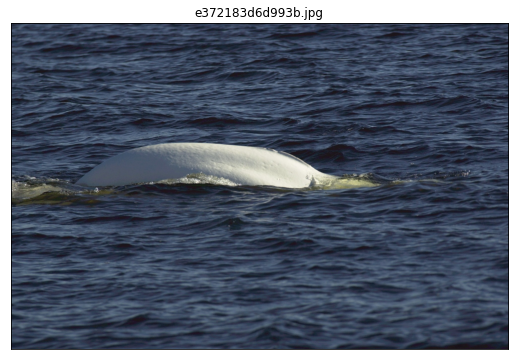

In [ ]:
# Randomly plot train image
path = SPLIT_TRAIN_DIR + np.random.choice(train_df['image'])
print("path", path)
im = plt.imread(path)
plt.figure(figsize=(15, 6))
plt.imshow(im)
plt.title(path.split("/")[-1])
plt.xticks([]), plt.yticks([])
train_df[train_df['image']==path.split('/')[-1]]

path /content/drive/MyDrive/HappyWhale_split_1124/test_split_0.01/4b5d86a218a4fe.jpg


Text(0.5, 1.0, '4b5d86a218a4fe.jpg')

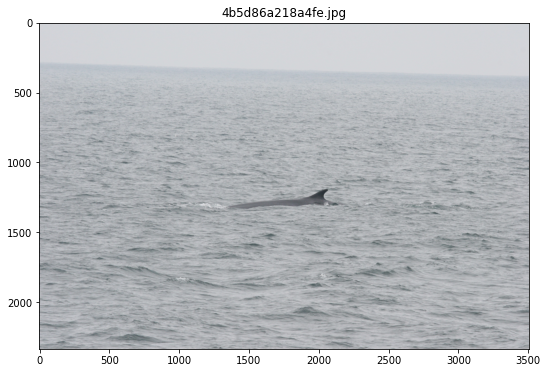

In [ ]:
# Randomly plot test image
TEST_IMAGES = glob(SPLIT_TEST_DIR + "*.jpg")
path = np.random.choice(TEST_IMAGES)
print("path", path)
im = plt.imread(path)
plt.figure(figsize=(15, 6))
plt.imshow(im)
plt.title(path.split("/")[-1])

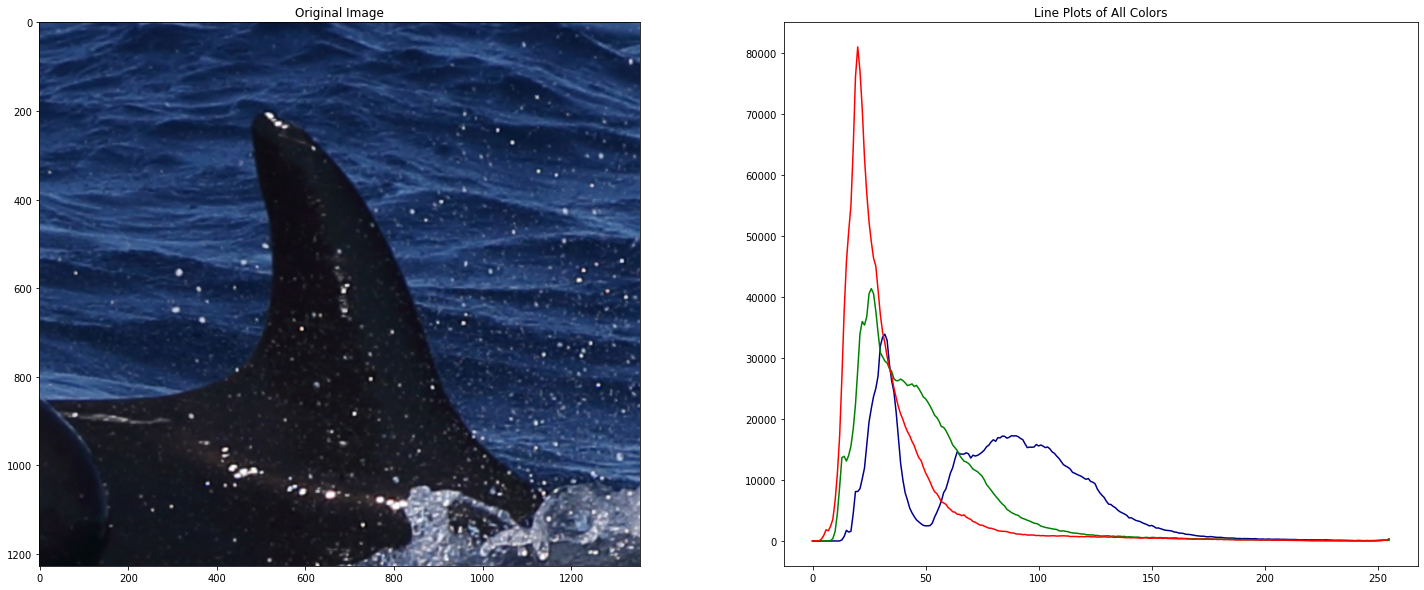

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
 
plt.subplot(1,2,1)
image = cv2.imread('/content/drive/MyDrive/HappyWhale_split_1124/train_split_0.02/0a4f4becf46a2e.jpg')
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
 
blue_histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
green_histogram = cv2.calcHist([image], [1], None, [256], [0, 256])
red_histogram = cv2.calcHist([image], [2], None, [256], [0, 256]) 

plt.subplot(1,2,2)
plt.title("Line Plots of All Colors")
plt.plot(blue_histogram,color="darkblue")
plt.plot(green_histogram,color="green")
plt.plot(red_histogram,color="red")

plt.show()

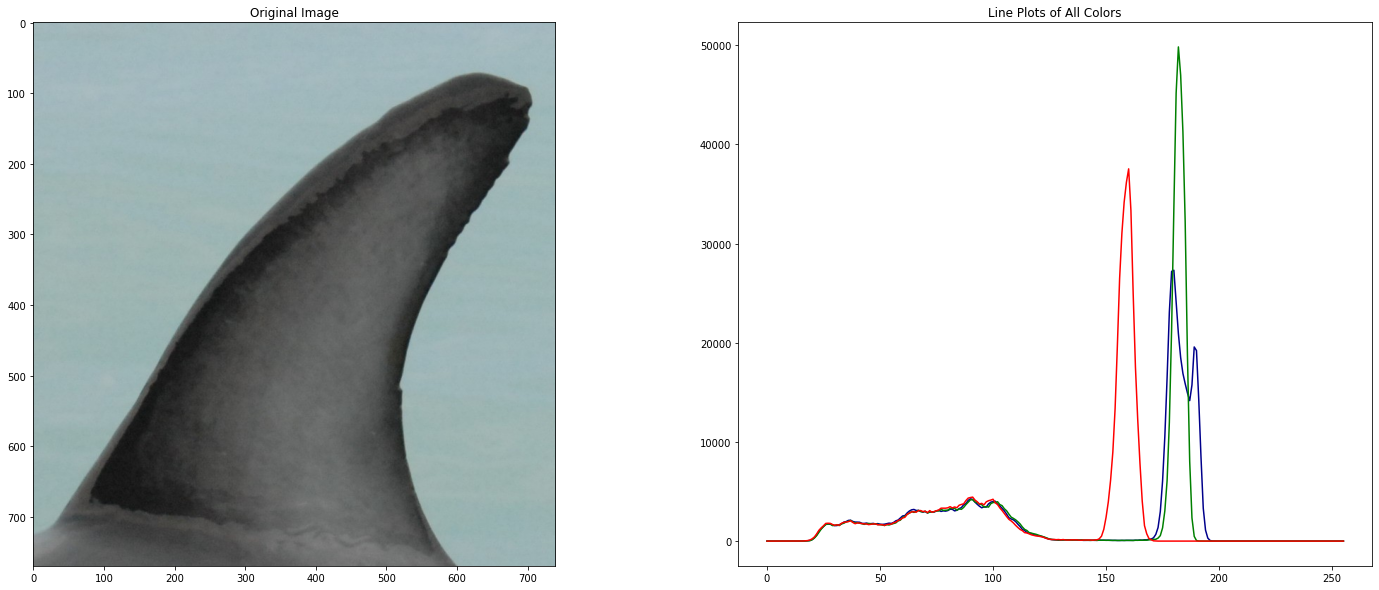

In [ ]:
plt.figure(figsize=(25,10))
 
plt.subplot(1,2,1)
image = cv2.imread('/content/drive/MyDrive/HappyWhale_split_1124/train_split_0.02/1ec8c238a6c161.jpg')
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
 
blue_histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
green_histogram = cv2.calcHist([image], [1], None, [256], [0, 256])
red_histogram = cv2.calcHist([image], [2], None, [256], [0, 256]) 

plt.subplot(1,2,2)
plt.title("Line Plots of All Colors")
plt.plot(blue_histogram,color="darkblue")
plt.plot(green_histogram,color="green")
plt.plot(red_histogram,color="red")

plt.show()

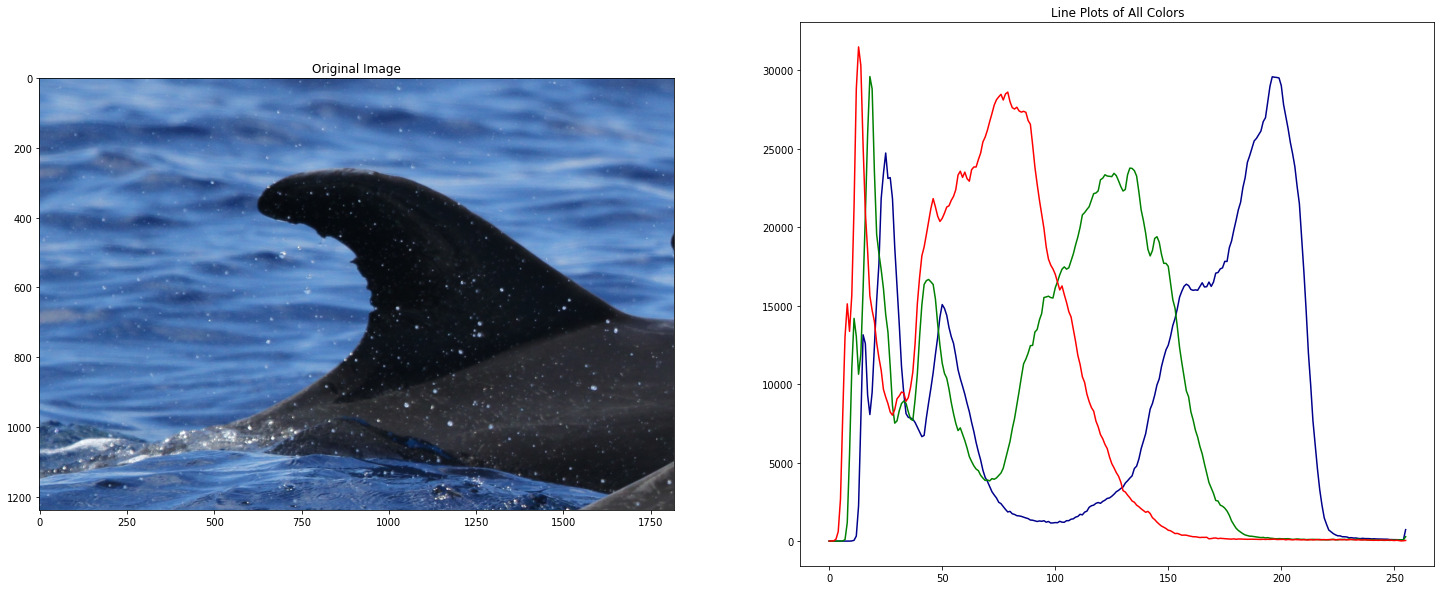

In [ ]:
plt.figure(figsize=(25,10))
 
plt.subplot(1,2,1)
image = cv2.imread('/content/drive/MyDrive/HappyWhale_split_1124/train_split_0.02/09387ec3423bd6.jpg')
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
 
blue_histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
green_histogram = cv2.calcHist([image], [1], None, [256], [0, 256])
red_histogram = cv2.calcHist([image], [2], None, [256], [0, 256]) 

plt.subplot(1,2,2)
plt.title("Line Plots of All Colors")
plt.plot(blue_histogram,color="darkblue")
plt.plot(green_histogram,color="green")
plt.plot(red_histogram,color="red")

plt.show()

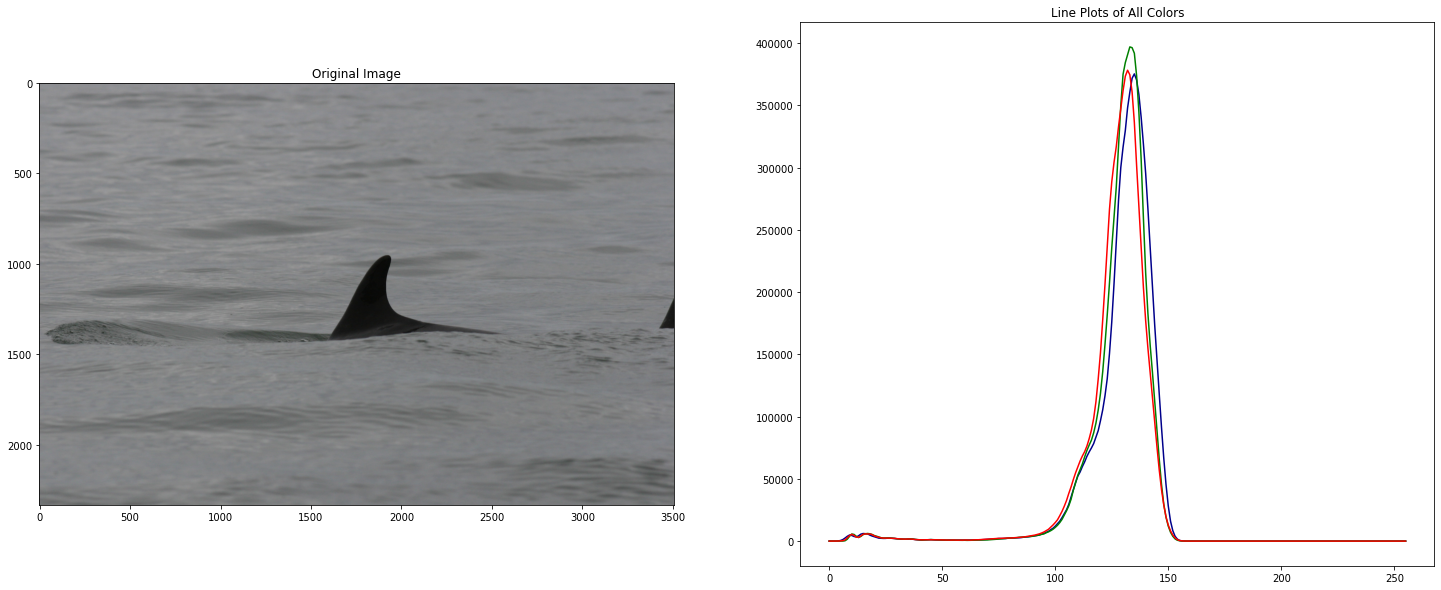

In [ ]:
plt.figure(figsize=(25,10))
 
plt.subplot(1,2,1)
image = cv2.imread('/content/drive/MyDrive/HappyWhale_split_1124/train_split_0.02/3bc14767e4ff4f.jpg')
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
 
blue_histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
green_histogram = cv2.calcHist([image], [1], None, [256], [0, 256])
red_histogram = cv2.calcHist([image], [2], None, [256], [0, 256]) 

plt.subplot(1,2,2)
plt.title("Line Plots of All Colors")
plt.plot(blue_histogram,color="darkblue")
plt.plot(green_histogram,color="green")
plt.plot(red_histogram,color="red")

plt.show()

# Data Preparation

## Data Augmentation

Several augmentation methods are applied to reduce overfitting and adding some noise.

In [ ]:
H = 256
W = 256

aug8p3 = A.OneOf([
            A.Sharpen(p=0.3),
            A.ToGray(p=0.3),
        ], p=0.5)

data_transforms = A.Compose([
    A.Resize(H, W),
    aug8p3,
    A.HorizontalFlip(),
    A.OneOf([
        A.RandomContrast(),
        A.RandomBrightness(),
    ]),
    A.ShiftScaleRotate(rotate_limit=10, scale_limit=0.15),
    A.RGBShift(),
    A.JpegCompression(80),
    A.HueSaturationValue(),
    A.Normalize(),
    ToTensorV2()
])

data_transforms_test = A.Compose([
    A.Resize(H, W),
    A.OneOf([
        A.RandomContrast(),
        A.RandomBrightness(),
    ]),
    A.HueSaturationValue(),
    A.Normalize(),
    ToTensorV2()
])


/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1179: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1153: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:317: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(


In [ ]:
print(data_transforms)

Compose([
  Resize(always_apply=False, p=1, height=256, width=256, interpolation=1),
  OneOf([
    Sharpen(always_apply=False, p=0.3, alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
    ToGray(always_apply=False, p=0.3),
  ], p=0.5),
  HorizontalFlip(always_apply=False, p=0.5),
  OneOf([
    RandomContrast(always_apply=False, p=0.5, limit=(-0.2, 0.2)),
    RandomBrightness(always_apply=False, p=0.5, limit=(-0.2, 0.2)),
  ], p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
  RGBShift(always_apply=False, p=0.5, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
  JpegCompression(always_apply=False, p=0.5, quality_lower=80, quality_upper=100),
  HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-20, 20), sat_shift_limit=

We can also visualize the data augmentation process to better understand it.

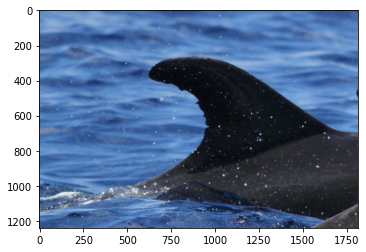

In [ ]:
image = cv2.imread('/content/drive/MyDrive/HappyWhale_split_1124/train_split_0.02/09387ec3423bd6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
H = 256
W = 256


data_transforms = A.Compose([
    A.Resize(H, W),
    A.Sharpen(p = 1),
    A.HorizontalFlip(p = 1),
    
    A.RandomContrast(p = 1),
    A.RandomBrightness(p=1),
    A.ShiftScaleRotate(rotate_limit=10, scale_limit=0.15),
    A.RGBShift(),
    A.JpegCompression(80),
    A.HueSaturationValue(),
    A.Normalize(),
])

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1179: FutureWarning:

RandomContrast has been deprecated. Please use RandomBrightnessContrast

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1153: FutureWarning:

This class has been deprecated. Please use RandomBrightnessContrast

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:317: FutureWarning:

JpegCompression has been deprecated. Please use ImageCompression



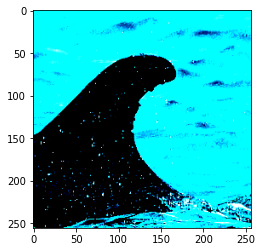

In [ ]:
img_show = data_transforms(image = image)['image']

plt.imshow(img_show)

## Category Numericalization

In [ ]:
def prepare_labels(y_train, y_val):
    onehot_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
    
    y_train = onehot_encoder.fit_transform(y_train)
    y_val = onehot_encoder.transform(y_val)
    label_name = onehot_encoder.get_feature_names_out()

    return y_train, y_val, label_name

In [ ]:
y_train, y_val, label_name = prepare_labels(train_df[['species']], val_df[['species']] )

In [ ]:
y_train.shape

(1020, 29)

In [ ]:
y_val.shape

(200, 29)

In [ ]:
label_name

array(['species_beluga', 'species_blue_whale',
       'species_bottlenose_dolphin', 'species_bottlenose_dolpin',
       'species_brydes_whale', 'species_commersons_dolphin',
       'species_common_dolphin', 'species_cuviers_beaked_whale',
       'species_dusky_dolphin', 'species_false_killer_whale',
       'species_fin_whale', 'species_frasiers_dolphin', 'species_globis',
       'species_gray_whale', 'species_humpback_whale',
       'species_kiler_whale', 'species_killer_whale',
       'species_long_finned_pilot_whale', 'species_melon_headed_whale',
       'species_minke_whale', 'species_pantropic_spotted_dolphin',
       'species_pilot_whale', 'species_pygmy_killer_whale',
       'species_sei_whale', 'species_short_finned_pilot_whale',
       'species_southern_right_whale', 'species_spinner_dolphin',
       'species_spotted_dolphin', 'species_white_sided_dolphin'],
      dtype=object)

## DataLoader

In [ ]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df = None, transform=None, y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
         
        img_name = os.path.join(str(self.datafolder), str(self.df[idx][0]))
        label = self.y[idx]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)['image']
        image = image*1.0/255
        
        return image, label

In [ ]:
train_dataset = WhaleDataset(
    datafolder='/content/drive/MyDrive/HappyWhale_split_1124/train_split_0.02/', 
    datatype='train', 
    df=train_df, 
    transform=data_transforms, 
    y=y_train
)


test_set = WhaleDataset(
    datafolder='/content/drive/MyDrive/HappyWhale_split_1124/val_split_0.004/', 
    datatype='test',
    df=val_df, 
    # transform=data_transforms,
    transform=data_transforms_test,
    y=y_val
)

In [ ]:
batch_size_= 32
num_workers = 4

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = batch_size_, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_set, batch_size= 16, num_workers=num_workers, pin_memory=True)

In [ ]:
def cuda(x):
    return x.cuda(non_blocking=True) if torch.cuda.is_available() else x

# CNN Model

## Model Building 

Define CNN model architecture.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # conv
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels= 3, out_channels= 32, padding=1, kernel_size= 3, stride=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels= 32, out_channels= 64 , kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size= 3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels= 128, out_channels= 128, kernel_size= 3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        # Relu
        self.relu = nn.ReLU()
        # Softmax
        self.softmax = nn.Softmax(dim = 1)
        # Dropout
        self.dropout = nn.Dropout(p=0.5)
        # Full Connected
        self.linear_1 = nn.Sequential(
            nn.Linear(16*16*128, 256),
            nn.BatchNorm1d(256),
        )
        self.linear_2 = nn.Linear(256, 29) 

        #End Your Code

    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)

      x = self.dropout(x)
      x = x.reshape(x.size(0), -1)
      x = self.linear_1(x)
      # x = self.softmax(x)
      x = self.relu(x)
      
      x = self.linear_2(x)
      pred = self.softmax(x)

      return pred

cnn = Net()


In [ ]:
cnn

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNor

In [ ]:
cnn.cuda()

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNor

Define loss function, optimizer and learning rate scheduler.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.0005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

##Model Fitting

Fit the model and record train accuracy and loss.

In [ ]:
n_epochs = 10
acc_list_cnn=[]
loss_list_cnn=[]

for epoch in range(1, n_epochs+1):
    train_loss = []
    #
    running_loss = 0
    correct = 0.0
    total = 0.0
    #
    for batch_i, (data, target) in tqdm(enumerate(train_loader), total = len(train_loader)):
        
        data, target = cuda(data), cuda(target)
        
        optimizer.zero_grad()
        output = cnn(data)
        
        loss = criterion(output, target)
        train_loss.append(loss.item())
       
        loss.backward()
        optimizer.step()
        # zero the parameter gradients
        # forward + backward + optimize
        predicted = torch.argmax(output.data, dim = 1)
        target_ind = torch.argmax(target, dim = 1)

        
        correct += predicted.eq(target_ind).sum() 
        total += float(len(target))
    # 
    accuracy = 100 * correct / total
    acc_list_cnn.append(accuracy.item())
    ##
    scheduler.step()
    loss_list_cnn.append(np.mean(train_loss))
    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, accuracy: {accuracy}')

100%|██████████| 32/32 [00:21<00:00,  1.47it/s]

Epoch 1, train loss: 3.1860, accuracy: 32.27408218383789



100%|██████████| 32/32 [00:21<00:00,  1.49it/s]

Epoch 2, train loss: 3.0518, accuracy: 42.303871154785156



100%|██████████| 32/32 [00:21<00:00,  1.48it/s]

Epoch 3, train loss: 2.9992, accuracy: 45.68023681640625



100%|██████████| 32/32 [00:21<00:00,  1.49it/s]

Epoch 4, train loss: 2.9684, accuracy: 49.056602478027344



100%|██████████| 32/32 [00:21<00:00,  1.49it/s]

Epoch 5, train loss: 2.9548, accuracy: 50.049652099609375



100%|██████████| 32/32 [00:21<00:00,  1.49it/s]

Epoch 6, train loss: 2.9432, accuracy: 50.54617691040039



100%|██████████| 32/32 [00:21<00:00,  1.48it/s]

Epoch 7, train loss: 2.9420, accuracy: 50.84408950805664



100%|██████████| 32/32 [00:21<00:00,  1.47it/s]

Epoch 8, train loss: 2.9441, accuracy: 51.042701721191406



100%|██████████| 32/32 [00:21<00:00,  1.47it/s]

Epoch 9, train loss: 2.9368, accuracy: 51.340614318847656



100%|██████████| 32/32 [00:21<00:00,  1.49it/s]

Epoch 10, train loss: 2.9377, accuracy: 51.241310119628906


In [ ]:
acc_list_cnn

[32.27408218383789,
 42.303871154785156,
 45.68023681640625,
 49.056602478027344,
 50.049652099609375,
 50.54617691040039,
 50.84408950805664,
 51.042701721191406,
 51.340614318847656,
 51.241310119628906]

In [ ]:
loss_list_cnn

[3.186039633474623,
 3.051824975153431,
 2.999164323803658,
 2.9683699076840036,
 2.9548250215904166,
 2.9432397060096265,
 2.9419754000380633,
 2.9441420665631695,
 2.936764999975761,
 2.9377287016250193]

## Evaluation

Calculate test accuracy.

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []
y_proba = []
with torch.no_grad():
    for batch_i, (data, target) in tqdm(enumerate(test_loader), total = len(test_loader)):
        data, target = cuda(data), cuda(target)
        output = cnn(data)
        proba = output.data.detach().cpu().numpy()
        predicted = torch.argmax(output.data, dim = 1).detach().cpu().numpy()
        target_ind = torch.argmax(target, dim = 1).detach().cpu().numpy()
        y_true.append(target_ind)
        y_pred.append(predicted)
        y_proba.append(proba)
        # correct += predicted==target_ind).sum() 
        # total += float(len(target))
        
# print(y_pred)
# print(y_true)
# print(y_proba)
# print('Test accuracy: %d %%' % (100 * correct / total))

100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


In [ ]:
true_labels = np.concatenate([item for item in y_true], axis = 0)
true_labels = [label_name.tolist()[i] for i in true_labels]

In [ ]:
len(true_labels)

199

In [ ]:
label = np.unique(np.array(true_labels))

In [ ]:
pred_labels = np.concatenate([item for item in y_pred], axis = 0)
pred_labels = [label_name.tolist()[i] for i in pred_labels]

In [ ]:
label
labels = [l.replace("species_", "") for l in label]
print(labels)

['beluga', 'blue_whale', 'bottlenose_dolphin', 'bottlenose_dolpin', 'common_dolphin', 'cuviers_beaked_whale', 'dusky_dolphin', 'false_killer_whale', 'fin_whale', 'gray_whale', 'humpback_whale', 'kiler_whale', 'killer_whale', 'long_finned_pilot_whale', 'melon_headed_whale', 'minke_whale', 'pilot_whale', 'sei_whale', 'short_finned_pilot_whale', 'southern_right_whale', 'spinner_dolphin', 'spotted_dolphin', 'white_sided_dolphin']


Plot Confusion Matrix.

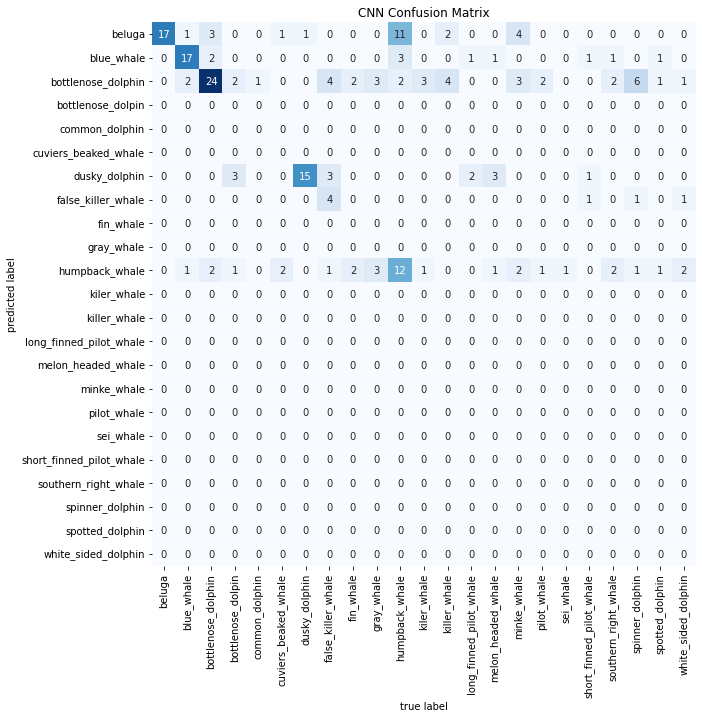

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score
import seaborn as sns

cnn_matrix = confusion_matrix(true_labels, pred_labels, labels = label)
fig, ax= plt.subplots(figsize=(10,10))
sns.heatmap(cnn_matrix.T, square=True, annot=True, 
            xticklabels=labels, yticklabels=labels,
            fmt='d', cbar=False, cmap='Blues', ax = ax)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('CNN Confusion Matrix')
cnn_matrix = confusion_matrix(true_labels, pred_labels)


In [ ]:
print('CNN Model Summary')
print('Recall:    {}'.format(recall_score(true_labels, pred_labels, average='weighted')))
print('Precision: {}'.format(precision_score(true_labels, pred_labels, average='weighted', zero_division=0)))
print('Accuracy:  {}'.format(accuracy_score(true_labels, pred_labels)))
print('F1 score:  {}'.format(f1_score(true_labels, pred_labels, average='weighted')))

CNN Model Summary
Recall:    0.4472361809045226
Precision: 0.2890783281486799
Accuracy:  0.4472361809045226
F1 score:  0.3403556439890189


# ResNet-50

##Model Building
Import the pre-trained model - ResNet-50.

In [ ]:
!pip install --upgrade certifi
!pip install pretrainedmodels
!git clone https://github.com/Cadene/pretrained-models.pytorch.git
!cd pretrained-models.pytorch
!python setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'pretrained-models.pytorch' already exists and is not an empty directory.
python3: can't open file 'setup.py': [Errno 2] No such file or directory


In [ ]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [ ]:
res = pretrainedmodels.resnet50()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Fine-Tuning

Print the parameters in the model.

In [ ]:
for para in res.parameters():
  print(para)

Streaming output truncated to the last 5000 lines.
         [[-6.3166e-03, -1.2048e-02,  8.8745e-04],
          [-1.4119e-02, -1.2392e-03,  6.1497e-03],
          [ 1.9563e-03,  1.2811e-03, -1.0937e-02]]],


        [[[ 1.1956e-02,  6.4232e-04, -4.1247e-03],
          [ 7.4465e-03,  6.4470e-03,  3.0302e-03],
          [ 2.5171e-02,  8.7522e-03,  1.7879e-03]],

         [[-1.0236e-02, -2.2165e-02, -1.3870e-02],
          [-1.4780e-02, -1.2104e-02, -3.0022e-02],
          [-1.9075e-03, -2.5575e-02, -2.5349e-02]],

         [[ 2.1705e-02,  1.8870e-02,  2.3259e-02],
          [ 1.3284e-02,  1.8016e-02,  2.2417e-02],
          [ 9.9931e-03, -8.8218e-03, -1.4500e-02]],

         ...,

         [[ 9.4819e-04,  2.6234e-03,  1.5482e-03],
          [ 4.4344e-03,  1.1787e-02,  1.2554e-03],
          [ 5.2904e-03,  7.9525e-03,  1.6375e-02]],

         [[-8.5535e-03, -1.7023e-02, -6.0318e-03],
          [ 9.4575e-03,  1.5215e-02,  4.4233e-03],
          [ 1.4191e-03,  1.4246e-02,  2.1175e-05]],

  

In [ ]:
parameters = res.state_dict()
parameters.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

Frozen layer 1 and layer 3.

In [ ]:
for name, param in res.named_parameters():
  if param.requires_grad and 'layer1' in name:
    param.requires_grad = False
  if param.requires_grad and 'layer3' in name:
    param.requires_grad = False

In [ ]:
#check
for name, param in res.named_parameters():
  if 'layer3' in name:
    print(name, param)

layer3.0.conv1.weight Parameter containing:
tensor([[[[ 1.4149e-02]],

         [[ 8.5007e-03]],

         [[ 1.9201e-02]],

         ...,

         [[-4.0301e-04]],

         [[-1.6396e-02]],

         [[ 6.3780e-03]]],


        [[[-7.8159e-03]],

         [[-1.5656e-04]],

         [[ 1.0262e-02]],

         ...,

         [[ 5.9090e-03]],

         [[ 8.4134e-02]],

         [[-2.8860e-03]]],


        [[[ 2.2822e-02]],

         [[-4.3230e-02]],

         [[ 7.8770e-03]],

         ...,

         [[ 1.4022e-02]],

         [[ 6.7142e-03]],

         [[-3.1446e-02]]],


        ...,


        [[[-8.5522e-05]],

         [[ 8.2215e-03]],

         [[-2.0979e-02]],

         ...,

         [[-1.9268e-02]],

         [[-1.8546e-02]],

         [[ 3.3627e-02]]],


        [[[-1.2550e-02]],

         [[-5.8194e-02]],

         [[ 5.3627e-03]],

         ...,

         [[ 7.3295e-03]],

         [[ 2.6446e-02]],

         [[ 3.0675e-02]]],


        [[[-3.8911e-03]],

         [[-2.7051e

##Transfer Learning

In [ ]:
res.last_linear = nn.Linear(res.last_linear.in_features, 29)

In [ ]:
# res.last_linear = nn.Sequential(
#     nn.Linear(in_features=res.last_linear.in_features, out_features=1024),
#     nn.ReLU(),
#     nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1),
#     nn.Dropout(p=0.5),
#     nn.Linear(in_features=1024, out_features=29),
# )

In [ ]:
res.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define loss funtion, optimizer and learning rate scheduler.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res.parameters(), lr=0.0005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## Model Fitting

Fit the model and record train accuracy and loss.

In [ ]:
n_epochs = 10
acc_list_res = []
loss_list_res = []
for epoch in range(1, n_epochs+1):
    train_loss = []
    correct = 0.0
    total = 0.0
    for batch_i, (data, target) in tqdm(enumerate(train_loader), total = len(train_loader)):
        data, target = cuda(data), cuda(target)

        optimizer.zero_grad()
        output = res(data)
        loss = criterion(output, target)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
        #
        predicted = torch.argmax(output.data, dim = 1)
        target_ind = torch.argmax(target, dim = 1)
        correct += predicted.eq(target_ind).sum()
        total += float(len(target))
    

    accuracy = 100 * correct / total
    acc_list_res.append(accuracy.item())

    #
    scheduler.step()
    
    #print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')
    loss_list_res.append(np.mean(train_loss))
    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, accuracy: {accuracy}')

100%|██████████| 32/32 [00:21<00:00,  1.52it/s]

Epoch 1, train loss: 1.6978, accuracy: 54.61767578125



100%|██████████| 32/32 [00:20<00:00,  1.54it/s]

Epoch 2, train loss: 1.1462, accuracy: 67.13008880615234



100%|██████████| 32/32 [00:20<00:00,  1.54it/s]

Epoch 3, train loss: 0.8239, accuracy: 77.15988159179688



100%|██████████| 32/32 [00:20<00:00,  1.53it/s]

Epoch 4, train loss: 0.5603, accuracy: 84.01191711425781



100%|██████████| 32/32 [00:20<00:00,  1.54it/s]

Epoch 5, train loss: 0.4269, accuracy: 88.67924499511719



100%|██████████| 32/32 [00:21<00:00,  1.51it/s]

Epoch 6, train loss: 0.3710, accuracy: 90.26811981201172



100%|██████████| 32/32 [00:20<00:00,  1.54it/s]

Epoch 7, train loss: 0.3252, accuracy: 91.45977783203125



100%|██████████| 32/32 [00:20<00:00,  1.52it/s]

Epoch 8, train loss: 0.3233, accuracy: 91.85700225830078



100%|██████████| 32/32 [00:20<00:00,  1.54it/s]

Epoch 9, train loss: 0.3253, accuracy: 91.65839385986328



100%|██████████| 32/32 [00:20<00:00,  1.54it/s]

Epoch 10, train loss: 0.3222, accuracy: 91.161865234375


In [ ]:
acc_list_res

[54.61767578125,
 67.13008880615234,
 77.15988159179688,
 84.01191711425781,
 88.67924499511719,
 90.26811981201172,
 91.45977783203125,
 91.85700225830078,
 91.65839385986328,
 91.161865234375]

In [ ]:
loss_list_res

[1.6977544617119602,
 1.1461584571063106,
 0.823853644150967,
 0.560299205347681,
 0.42693787002969763,
 0.37098330407047836,
 0.3252325572501092,
 0.3232641737757548,
 0.3253258837023277,
 0.3222037886915947]

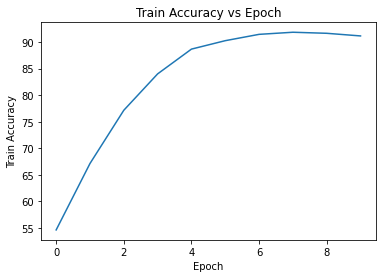

In [ ]:
plt.plot(range(0,10,1), acc_list_res)
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Epoch")
plt.show()
plt.close()

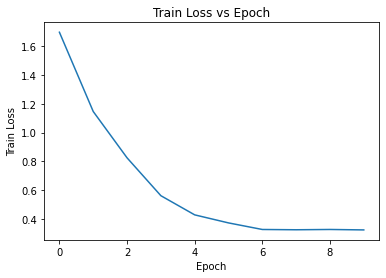

In [ ]:
plt.plot(range(0,10,1), loss_list_res)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss vs Epoch")
plt.show()
plt.close()

## Evaluation

Calculate test accuracy.

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []
# y_proba = []
with torch.no_grad():
    for batch_i, (data, target) in tqdm(enumerate(test_loader), total = len(test_loader)):
        data, target = cuda(data), cuda(target)
        output = res(data)
        proba = output.data.detach().cpu().numpy()
        predicted = torch.argmax(output.data, dim = 1).detach().cpu().numpy()
        target_ind = torch.argmax(target, dim = 1).detach().cpu().numpy()
        y_true.append(target_ind)
        y_pred.append(predicted)
        # y_proba.append(proba)

100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


In [ ]:
# decode true label
true_labels = np.concatenate([item for item in y_true], axis = 0)
true_labels = [label_name.tolist()[i] for i in true_labels]
label = np.unique(np.array(true_labels))
# decode predict label
pred_labels = np.concatenate([item for item in y_pred], axis = 0)
pred_labels = [label_name.tolist()[i] for i in pred_labels]


In [ ]:
label
labels = [l.replace("species_", "") for l in label]
print(labels)

['beluga', 'blue_whale', 'bottlenose_dolphin', 'bottlenose_dolpin', 'common_dolphin', 'cuviers_beaked_whale', 'dusky_dolphin', 'false_killer_whale', 'fin_whale', 'gray_whale', 'humpback_whale', 'kiler_whale', 'killer_whale', 'long_finned_pilot_whale', 'melon_headed_whale', 'minke_whale', 'pilot_whale', 'sei_whale', 'short_finned_pilot_whale', 'southern_right_whale', 'spinner_dolphin', 'spotted_dolphin', 'white_sided_dolphin']


Plot Confusion matrix

Text(0.5, 1.0, 'ResNet-50 Confusion Matrix')

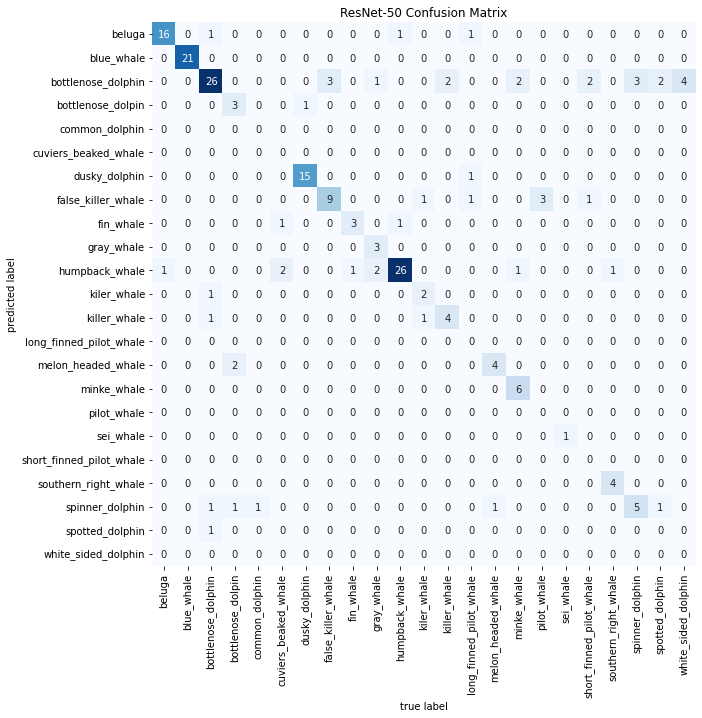

In [ ]:
res_matrix = confusion_matrix(true_labels, pred_labels, labels = label)
fig, ax= plt.subplots(figsize=(10,10))
sns.heatmap(res_matrix.T, square=True, annot=True, 
            xticklabels=labels, yticklabels=labels,
            fmt='d', cbar=False, cmap='Blues', ax = ax)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('ResNet-50 Confusion Matrix')

In [ ]:
print('ResNet-50 Model Summary')
print('Recall:    {}'.format(recall_score(true_labels, pred_labels, average='weighted')))
print('Precision: {}'.format(precision_score(true_labels, pred_labels, average='weighted', zero_division=0)))
print('Accuracy:  {}'.format(accuracy_score(true_labels, pred_labels)))
print('F1 score:  {}'.format(f1_score(true_labels, pred_labels, average='weighted')))

ResNet-50 Model Summary
Recall:    0.7437185929648241
Precision: 0.6971792225662193
Accuracy:  0.7437185929648241
F1 score:  0.7089605119209851


# DenseNet-121

##Model Building

Import the pre-trained model: DenseNet-121.

In [ ]:
import torch
densenet = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##Fine-Tuning

In [ ]:
for para in densenet.parameters():
  print(para)

Streaming output truncated to the last 5000 lines.
         [[-2.6082e-07]]],


        [[[-1.1559e-03]],

         [[-1.0995e-02]],

         [[-3.5921e-02]],

         ...,

         [[-5.2694e-08]],

         [[ 3.6853e-09]],

         [[-3.2316e-08]]]], requires_grad=True)
Parameter containing:
tensor([0.1506, 0.1538, 0.1703, 0.1859, 0.1776, 0.1693, 0.1958, 0.1738, 0.0844,
        0.1714, 0.1776, 0.1595, 0.1666, 0.1738, 0.1738, 0.1547, 0.1774, 0.1798,
        0.1504, 0.1554, 0.1800, 0.2083, 0.1618, 0.1747, 0.1512, 0.1754, 0.2378,
        0.2030, 0.1351, 0.1999, 0.1490, 0.1590, 0.1568, 0.2495, 0.1580, 0.1524,
        0.1868, 0.1828, 0.1597, 0.1714, 0.1603, 0.2067, 0.2020, 0.1626, 0.1815,
        0.1790, 0.1752, 0.1423, 0.1819, 0.1631, 0.1604, 0.1596, 0.1777, 0.1356,
        0.1639, 0.1480, 0.1699, 0.1832, 0.1184, 0.1945, 0.1530, 0.1657, 0.1545,
        0.1706, 0.1584, 0.1492, 0.1769, 0.1737, 0.1607, 0.1519, 0.1218, 0.1537,
        0.1740, 0.1494, 0.1707, 0.1563, 0.1419, 0.1758, 0.17

In [ ]:
parameters = res.state_dict()
parameters.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [ ]:
for name, param in densenet.named_parameters():
  if param.requires_grad and 'layer1' in name:
    param.requires_grad = False
  if param.requires_grad and 'layer3' in name:
    param.requires_grad = False

In [ ]:
#check
for name, param in densenet.named_parameters():
  if 'layer3' in name:
    print(name, param)

features.denseblock1.denselayer3.norm1.weight Parameter containing:
tensor([1.3429e-01, 1.1026e-01, 1.3621e-01, 1.2550e-01, 1.3910e-01, 1.2049e-01,
        6.7574e-02, 9.6470e-02, 5.3939e-08, 1.2034e-01, 1.5248e-01, 1.0803e-01,
        1.3910e-01, 8.2659e-02, 5.4246e-02, 3.9886e-09, 1.1097e-01, 1.7664e-04,
        6.1571e-02, 1.1937e-01, 8.1863e-02, 1.0260e-01, 1.1840e-01, 2.7051e-02,
        1.3962e-01, 9.4052e-02, 7.7856e-02, 1.0046e-01, 1.0166e-01, 9.7604e-02,
        9.7519e-02, 7.1878e-02, 7.4652e-02, 1.1047e-01, 1.5173e-01, 1.2228e-01,
        6.8002e-02, 1.1403e-01, 1.2356e-01, 1.0293e-01, 9.1066e-02, 2.3296e-02,
        9.0284e-02, 9.2128e-02, 1.7428e-01, 9.2569e-02, 1.0973e-01, 9.0921e-02,
        1.3216e-01, 9.3489e-02, 1.8924e-01, 1.0449e-01, 1.2513e-01, 1.1610e-01,
        1.1407e-01, 9.8878e-02, 1.2624e-01, 8.4699e-02, 1.1848e-01, 1.2359e-01,
        1.0860e-01, 1.2674e-10, 1.1373e-01, 7.7830e-02, 5.7821e-02, 1.4327e-01,
        2.0433e-01, 1.6506e-01, 8.9849e-02, 2.0659e-

## Transfer Learning

In [ ]:
densenet.classifier = nn.Linear(in_features=1024, out_features=29, bias=True)

In [ ]:
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
densenet.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Define loss function, optimizer and learning rate scheduler.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet.parameters(), lr=0.0005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## Model Fitting

Fit the model and record train accuracy and loss.

In [ ]:
n_epochs = 10
acc_list_dense = []
loss_list_dense = []

for epoch in range(1, n_epochs+1):
    train_loss = []
    correct = 0.0
    total = 0.0
    for batch_i, (data, target) in tqdm(enumerate(train_loader), total = len(train_loader)):
        data, target = cuda(data), cuda(target)

        optimizer.zero_grad()
        output = densenet(data)
        loss = criterion(output, target)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
        #
        predicted = torch.argmax(output.data, dim = 1)
        target_ind = torch.argmax(target, dim = 1)
        correct += predicted.eq(target_ind).sum()
        total += float(len(target))
    

    accuracy = 100 * correct / total
    acc_list_dense.append(accuracy.item())

    #
    scheduler.step()
    
    #print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')
    loss_list_dense.append(np.mean(train_loss))
    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, accuracy: {accuracy}')

100%|██████████| 32/32 [00:23<00:00,  1.37it/s]

Epoch 1, train loss: 1.8981, accuracy: 52.23435974121094



100%|██████████| 32/32 [00:24<00:00,  1.29it/s]

Epoch 2, train loss: 1.0629, accuracy: 70.40715026855469



100%|██████████| 32/32 [00:23<00:00,  1.36it/s]

Epoch 3, train loss: 0.6974, accuracy: 82.91956329345703



100%|██████████| 32/32 [00:23<00:00,  1.37it/s]

Epoch 4, train loss: 0.4675, accuracy: 89.37438201904297



100%|██████████| 32/32 [00:23<00:00,  1.37it/s]

Epoch 5, train loss: 0.3774, accuracy: 92.45282745361328



100%|██████████| 32/32 [00:23<00:00,  1.35it/s]

Epoch 6, train loss: 0.3604, accuracy: 91.95630645751953



100%|██████████| 32/32 [00:23<00:00,  1.37it/s]

Epoch 7, train loss: 0.3290, accuracy: 93.44587707519531



100%|██████████| 32/32 [00:23<00:00,  1.38it/s]

Epoch 8, train loss: 0.3155, accuracy: 94.1410140991211



100%|██████████| 32/32 [00:23<00:00,  1.36it/s]

Epoch 9, train loss: 0.3214, accuracy: 93.44587707519531



100%|██████████| 32/32 [00:23<00:00,  1.38it/s]

Epoch 10, train loss: 0.3231, accuracy: 93.34657287597656


In [ ]:
acc_list_dense

[52.23435974121094,
 70.40715026855469,
 82.91956329345703,
 89.37438201904297,
 92.45282745361328,
 91.95630645751953,
 93.44587707519531,
 94.1410140991211,
 93.44587707519531,
 93.34657287597656]

In [ ]:
loss_list_dense

[1.898081226520579,
 1.0629436050973557,
 0.6973687464977426,
 0.46748900559914547,
 0.3773886884995742,
 0.3603654561053039,
 0.32895796884145057,
 0.31552876124824253,
 0.3214247090668929,
 0.32305522365245454]

## Evaluation

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []
# y_proba = []
with torch.no_grad():
    for batch_i, (data, target) in tqdm(enumerate(test_loader), total = len(test_loader)):
        data, target = cuda(data), cuda(target)
        output = densenet(data)
        proba = output.data.detach().cpu().numpy()
        predicted = torch.argmax(output.data, dim = 1).detach().cpu().numpy()
        target_ind = torch.argmax(target, dim = 1).detach().cpu().numpy()
        y_true.append(target_ind)
        y_pred.append(predicted)
        # y_proba.append(proba)

100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


In [ ]:
# decode true label
true_labels = np.concatenate([item for item in y_true], axis = 0)
true_labels = [label_name.tolist()[i] for i in true_labels]
label = np.unique(np.array(true_labels))
# decode predict label
pred_labels = np.concatenate([item for item in y_pred], axis = 0)
pred_labels = [label_name.tolist()[i] for i in pred_labels]

In [ ]:
label

array(['species_beluga', 'species_blue_whale',
       'species_bottlenose_dolphin', 'species_bottlenose_dolpin',
       'species_common_dolphin', 'species_cuviers_beaked_whale',
       'species_dusky_dolphin', 'species_false_killer_whale',
       'species_fin_whale', 'species_gray_whale',
       'species_humpback_whale', 'species_kiler_whale',
       'species_killer_whale', 'species_long_finned_pilot_whale',
       'species_melon_headed_whale', 'species_minke_whale',
       'species_pilot_whale', 'species_sei_whale',
       'species_short_finned_pilot_whale', 'species_southern_right_whale',
       'species_spinner_dolphin', 'species_spotted_dolphin',
       'species_white_sided_dolphin'], dtype='<U32')

In [ ]:
label
labels = [l.replace("species_", "") for l in label]
print(labels)

['beluga', 'blue_whale', 'bottlenose_dolphin', 'bottlenose_dolpin', 'common_dolphin', 'cuviers_beaked_whale', 'dusky_dolphin', 'false_killer_whale', 'fin_whale', 'gray_whale', 'humpback_whale', 'kiler_whale', 'killer_whale', 'long_finned_pilot_whale', 'melon_headed_whale', 'minke_whale', 'pilot_whale', 'sei_whale', 'short_finned_pilot_whale', 'southern_right_whale', 'spinner_dolphin', 'spotted_dolphin', 'white_sided_dolphin']


Plot confusion matrix.

Text(0.5, 1.0, 'DenseNet-121 Confusion Matrix')

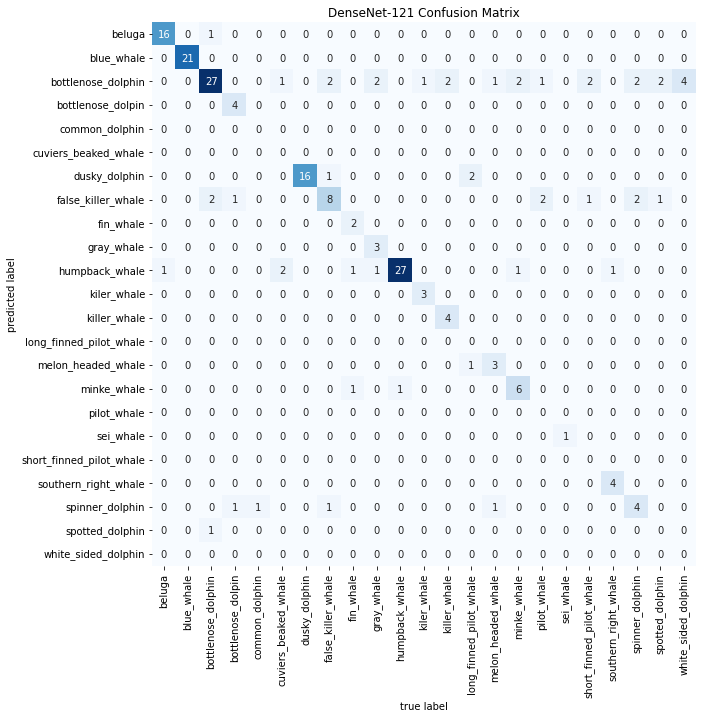

In [ ]:
dense_matrix = confusion_matrix(true_labels, pred_labels, labels = label)
fig, ax= plt.subplots(figsize=(10,10))
sns.heatmap(dense_matrix.T, square=True, annot=True, 
            xticklabels=labels, yticklabels=labels,
            fmt='d', cbar=False, cmap='Blues', ax = ax)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('DenseNet-121 Confusion Matrix')

In [ ]:
print('DenseNet-121 Model Summary')
print('Recall:    {}'.format(recall_score(true_labels, pred_labels, average='weighted')))
print('Precision: {}'.format(precision_score(true_labels, pred_labels, average='weighted', zero_division=0)))
print('Accuracy:  {}'.format(accuracy_score(true_labels, pred_labels)))
print('F1 score:  {}'.format(f1_score(true_labels, pred_labels, average='weighted')))

DenseNet-121 Model Summary
Recall:    0.7487437185929648
Precision: 0.7132546221344924
Accuracy:  0.7487437185929648
F1 score:  0.7155141452634365


# ConvNeXt

## Data Augmentation

The ConvNeXt model has its own data augmentation mothods, so we rebuild the train_transforms and test_transforms functions.

In [ ]:
from timm.data.constants import \
    IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

NORMALIZE_MEAN = IMAGENET_DEFAULT_MEAN
NORMALIZE_STD = IMAGENET_DEFAULT_STD
SIZE = 256


train_transforms = T.Compose([T.Resize([SIZE, SIZE]),
                              T.ToTensor(),
                              T.RandomAdjustSharpness(sharpness_factor=2, p = 0.3),
                              T.RandomGrayscale(p=0.3),
                              T.ColorJitter(brightness=(0.5,1.5),contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
                              T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                              T.RandomHorizontalFlip(),
                              T.RandomRotation(10),
                              T.Normalize(NORMALIZE_MEAN, NORMALIZE_MEAN),
])

test_transforms = T.Compose([ 
    T.Resize([SIZE, SIZE]),
    T.ToTensor(),
    T.ColorJitter(brightness=(0.5,1.5),contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
    T.Normalize(NORMALIZE_MEAN, NORMALIZE_MEAN),
])

## DataLoader

In [ ]:
from torchvision.datasets.folder import pil_loader
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df = None, transform=None, y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        
        img_name = os.path.join(str(self.datafolder), str(self.df[idx][0]))
        label = self.y[idx]
        img = pil_loader(img_name)

        image = self.transform(img)
        
        return image, label

In [ ]:
train_dataset = WhaleDataset(
    datafolder='/content/drive/MyDrive/HappyWhale_split_1124/train_split_0.02/', 
    datatype='train', 
    df=train_df, 
    transform=train_transforms, 
    y=y_train
)


test_set = WhaleDataset(
    datafolder='/content/drive/MyDrive/HappyWhale_split_1124/val_split_0.004/', 
    datatype='test',
    df=val_df, 
    transform=test_transforms,
    y=y_val
)

In [ ]:
batch_size_= 32
num_workers = 4

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = batch_size_, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_set, batch_size= 16, num_workers=num_workers, pin_memory=True)

## Model Building

Import the pre-trained model: ConvNeXt.

In [ ]:
model_name = "convnext_xlarge_in22k"
# create a ConvNeXt model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/convnext.py
convnext = create_model(model_name, pretrained=True)

## Transfer Learning

In [ ]:
convnext.head.fc = nn.Linear(in_features=2048, out_features=29, bias=True)
convnext.cuda()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((256,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
          (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELU(approximate='none')
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=1024, out_features=256, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
          (norm): LayerNorm((256,

Define loss function, optimizer and learning rate scheduler.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext.parameters(), lr=0.0005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## Model Fitting

Fit the model with train image and record train accuracy and loss.

In [ ]:
n_epochs = 10
acc_list_convnext = []
loss_list_convnext = []

for epoch in range(1, n_epochs+1):
    train_loss = []
    correct = 0.0
    total = 0.0
    for batch_i, (data, target) in tqdm(enumerate(train_loader), total = len(train_loader)):
        data, target = cuda(data), cuda(target)

        optimizer.zero_grad()
        output = convnext(data)
        loss = criterion(output, target)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
        #
        predicted = torch.argmax(output.data, dim = 1)
        target_ind = torch.argmax(target, dim = 1)
        correct += predicted.eq(target_ind).sum()
        total += float(len(target))
    

    accuracy = 100 * correct / total
    acc_list_convnext.append(accuracy.item())

    #
    scheduler.step()
    
    #print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')
    loss_list_convnext.append(np.mean(train_loss))
    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, accuracy: {accuracy}')

100%|██████████| 32/32 [00:44<00:00,  1.38s/it]

Epoch 1, train loss: 1.6800, accuracy: 53.22740936279297



100%|██████████| 32/32 [00:39<00:00,  1.24s/it]

Epoch 2, train loss: 0.9891, accuracy: 70.50645446777344



100%|██████████| 32/32 [00:39<00:00,  1.24s/it]

Epoch 3, train loss: 0.6583, accuracy: 80.23833465576172



100%|██████████| 32/32 [00:39<00:00,  1.24s/it]

Epoch 4, train loss: 0.2989, accuracy: 91.85700225830078



100%|██████████| 32/32 [00:39<00:00,  1.24s/it]

Epoch 5, train loss: 0.2182, accuracy: 93.84310150146484



100%|██████████| 32/32 [00:39<00:00,  1.24s/it]

Epoch 6, train loss: 0.1279, accuracy: 96.92154693603516



100%|██████████| 32/32 [00:39<00:00,  1.25s/it]

Epoch 7, train loss: 0.1006, accuracy: 98.11320495605469



100%|██████████| 32/32 [00:39<00:00,  1.24s/it]

Epoch 8, train loss: 0.0960, accuracy: 97.71598815917969



100%|██████████| 32/32 [00:39<00:00,  1.24s/it]

Epoch 9, train loss: 0.0758, accuracy: 98.80834197998047



100%|██████████| 32/32 [00:39<00:00,  1.24s/it]

Epoch 10, train loss: 0.0851, accuracy: 98.21250915527344


In [ ]:
acc_list_convnext

[53.22740936279297,
 70.50645446777344,
 80.23833465576172,
 91.85700225830078,
 93.84310150146484,
 96.92154693603516,
 98.11320495605469,
 97.71598815917969,
 98.80834197998047,
 98.21250915527344]

In [ ]:
loss_list_convnext

[1.6800173724454377,
 0.9891161855159794,
 0.6583483012483498,
 0.2989034276514,
 0.21821354047884445,
 0.12789235812383595,
 0.10056279897675609,
 0.09601289854147885,
 0.07580092099913713,
 0.08509431157670519]

##Evaluation

Calculate the test accuracy.

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []
# y_proba = []
with torch.no_grad():
    for batch_i, (data, target) in tqdm(enumerate(test_loader), total = len(test_loader)):
        data, target = cuda(data), cuda(target)
        output = convnext(data)
        proba = output.data.detach().cpu().numpy()
        predicted = torch.argmax(output.data, dim = 1).detach().cpu().numpy()
        target_ind = torch.argmax(target, dim = 1).detach().cpu().numpy()
        y_true.append(target_ind)
        y_pred.append(predicted)
        # y_proba.append(proba)

100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


In [ ]:
# decode true label
true_labels = np.concatenate([item for item in y_true], axis = 0)
true_labels = [label_name.tolist()[i] for i in true_labels]
label = np.unique(np.array(true_labels))
# decode predict label
pred_labels = np.concatenate([item for item in y_pred], axis = 0)
pred_labels = [label_name.tolist()[i] for i in pred_labels]

In [ ]:
label
labels = [l.replace("species_", "") for l in label]
print(labels)

['beluga', 'blue_whale', 'bottlenose_dolphin', 'bottlenose_dolpin', 'common_dolphin', 'cuviers_beaked_whale', 'dusky_dolphin', 'false_killer_whale', 'fin_whale', 'gray_whale', 'humpback_whale', 'kiler_whale', 'killer_whale', 'long_finned_pilot_whale', 'melon_headed_whale', 'minke_whale', 'pilot_whale', 'sei_whale', 'short_finned_pilot_whale', 'southern_right_whale', 'spinner_dolphin', 'spotted_dolphin', 'white_sided_dolphin']


Text(0.5, 1.0, 'ConvNeXt Confusion Matrix')

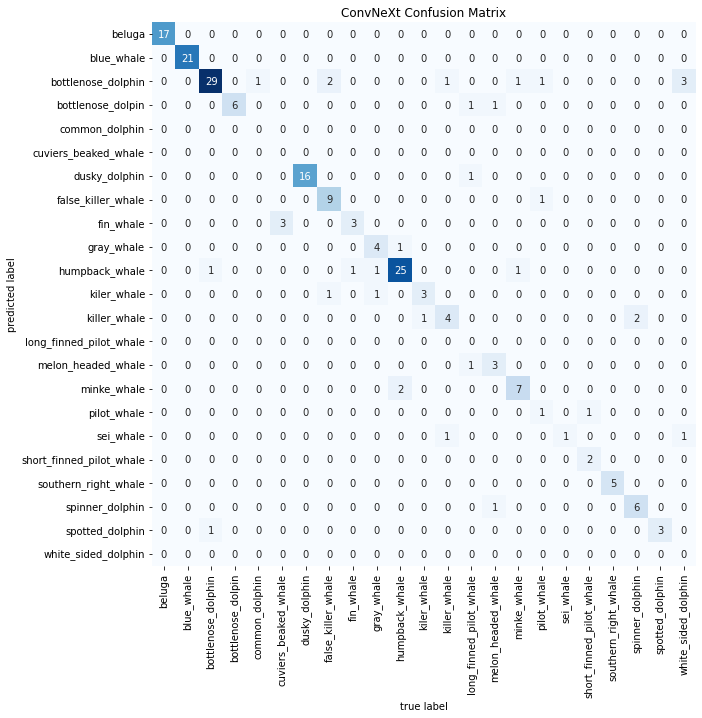

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score
import seaborn as sns

convnext_matrix = confusion_matrix(true_labels, pred_labels, labels = label)
fig, ax= plt.subplots(figsize=(10,10))
sns.heatmap(convnext_matrix.T, square=True, annot=True, 
            xticklabels=labels, yticklabels=labels,
            fmt='d', cbar=False, cmap='Blues', ax = ax)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('ConvNeXt Confusion Matrix')

In [ ]:
print('ConvNeXt Model Summary')
print('Recall:    {}'.format(recall_score(true_labels, pred_labels, average='weighted')))
print('Precision: {}'.format(precision_score(true_labels, pred_labels, average='weighted', zero_division=0)))
print('Accuracy:  {}'.format(accuracy_score(true_labels, pred_labels)))
print('F1 score:  {}'.format(f1_score(true_labels, pred_labels, average='weighted')))

ConvNeXt Model Summary
Recall:    0.8291457286432161
Precision: 0.7963502357778104
Accuracy:  0.8291457286432161
F1 score:  0.8071504403358181


# Model Comparison

Plot the train accuracy and loss for all models.

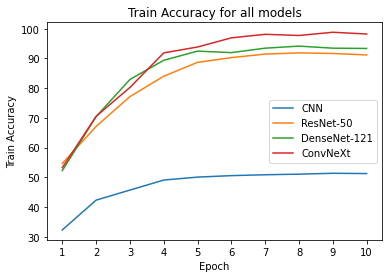

In [ ]:
plt.title("Train Accuracy for all models")
plt.plot(range(1,11,1),acc_list_cnn, label = "CNN" )
plt.plot(range(1,11,1),acc_list_res, label = 'ResNet-50')
plt.plot(range(1,11,1),acc_list_dense, label = 'DenseNet-121')
plt.plot(range(1,11,1),acc_list_convnext, label = 'ConvNeXt')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.xticks(np.arange(1, 11, 1))
plt.legend()
plt.show()

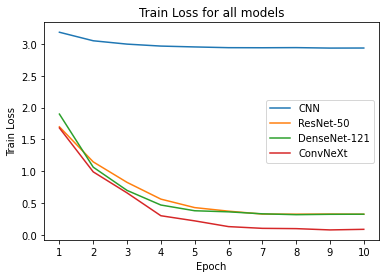

In [ ]:
plt.title("Train Loss for all models")
plt.plot(range(1,11,1),loss_list_cnn, label = "CNN" )
plt.plot(range(1,11,1),loss_list_res, label = 'ResNet-50')
plt.plot(range(1,11,1),loss_list_dense, label = 'DenseNet-121')
plt.plot(range(1,11,1),loss_list_convnext, label = 'ConvNeXt')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.xticks(np.arange(1, 11, 1))
plt.legend()
plt.show()